In [1]:
'''
Utils
'''

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import random
import torch
import time

def set_seed_torch(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def MAPE(pred, act):
    '''
    returns mean absolute percentage error for each pytorch batch
    '''
    return 100/torch.numel(act) * torch.sum(torch.abs((act-pred)/act))

def samplewise_MAPE(pred, act):
    '''
    returns mean absolute percentage error for each sample
    '''
    return 100/act.shape[1] * np.sum(np.abs((act-pred)/act), axis=1)

def torch_samplewise_MAPE(pred, act):
    '''
    returns mean absolute percentage error for each sample
    '''
    return 100/act.size()[1] * torch.sum(torch.abs((act-pred)/act), axis=1)

def samplewise_MSE(act, pred):
    '''
    returns mean squared error for each sample
    '''
    return np.sum((act-pred)**2, axis=1)/act.shape[1]

def samplewise_MAE(pred, act):
    '''
    returns mean absolute error for each sample
    '''
    return 1/act.shape[1] * np.sum(np.abs(act-pred), axis=1)

def speed_test(model, dim, num_test=1e5, precision='full', device='cuda'):
    test_tensor = torch.randn(int(num_test), int(dim))
    
    if device == 'cuda':
        model.to(device)
        test_tensor = test_tensor.to(device)
        
    if precision == 'half':
        model.half()
        test_tensor = test_tensor.half()
        
    t0 = time.time()
    model(test_tensor)
    dt = time.time() - t0
    
    print(f'Speed test run on {num_test:0.2e} samples,\nTook {dt} seconds in total, {dt/num_test:0.4e} seconds per sample')
    return dt

In [2]:
'''
Dataset
'''


import torch

import pandas as pd
import numpy as np

# build a dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, channel_size=None):
        '''
        prepare dataset for NN training, x and y can be either pd.DataFrames or np.array
        
        channel_size: If not None, y will be shaped into a 2D array with shape (channel, channel_size)
            If None, y will be a 1D array
        '''
        if isinstance(x, pd.DataFrame):
            self.x = x.to_numpy().astype(np.float32)
            self.x_headings = x.columns.values # saves the headings for referencing
            self.len = len(x.index)
        else:
            self.x = x.astype(np.float32)
            self.x_headings = None 
            self.len = len(x)
            
        if isinstance(y, pd.DataFrame):
            self.y = y.to_numpy().astype(np.float32)
            self.y_headings = y.columns.values
        else:
            self.y = y.astype(np.float32)
            self.y_headings = None
        
        assert len(self.x) == len(self.y)


    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    # check the dtype of the dataset for pytorch training
    def check_dtype(self):
        if self.x.dtype != np.float32:
            print(f'Detected {self.x.dtype} in dataset.x, converting it to np.float32')
            self.x = self.x.astype(np.float32)
        if self.y.dtype != np.float32:
            print(f'Detected {self.y.dtype} in dataset.y, converting it to np.float32')
            self.y = self.y.astype(np.float32)

def to_dense(sparse):
    dense = np.zeros([len(sparse), np.max(sparse)+1])
    for idx, i in enumerate(sparse):
        dense[idx, i] = 1
    return dense

In [3]:
'''
Model
'''


from torch import nn
import torch
import copy

import numpy as np

def model_summary(model):
    '''
    prints a summery of the model, mainly for debugging uses
    '''
    print(next(model.named_modules())[1])
    
    param_size = 0
    trainable_param_size = 0
    for name, param in model.named_parameters():
        nparam = param.nelement()
        print(f'{name}, {nparam}, trainable: {param.requires_grad}')
        param_size += nparam
        if param.requires_grad:
            trainable_param_size += nparam
    print(f'Total parameter = {param_size}')
    print(f'Total trainable parameter = {trainable_param_size}\n')
    # time.sleep(1)

def initialise_weights(layers, a, nonlinearity='leaky_relu'):
    '''
    Initialise weights for dense layers
    '''
    for layer in layers[:-1]: # skip the last layer, which is either Lrelu or nn.Linear linking the output layer
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlinearity)
        
        
class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, 
                 alpha=0.3, 
                 dropout=None, dropout_on_last_layer=False,
                 ):
        '''
        fully connected neural net
        
        branching: the nth last layer at which the network splits in half
        alpha: sets the negative gradient for the leakyrelu activation
        dropout: None or float or list of float for nn.Dropout
        dropout_on_last_layer: whether to add Dropout right before the output
        activation_on_last_layer: whether to add nonlinear activation right before the output layer
        '''
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        hdim = np.array([input_dim]+hidden_dim)
        
        if isinstance(dropout, float):
            dropout = [dropout]*len(hdim)
        
        # assert len(dropout) == len(hdim)
        
        hidden_layers=[]
        for i in range(len(hidden_dim)):
            layer = []
            layer.append(nn.Linear(hdim[i], hdim[i+1]))
            layer.append(nn.LeakyReLU(negative_slope=alpha))
            if dropout is not None:
                layer.append(nn.Dropout(dropout[i]))
            hidden_layers.append(layer)
            
        if not dropout_on_last_layer and dropout is not None:
            del hidden_layers[-1][2]
            
        self.layers = nn.Sequential(*sum(hidden_layers, []),
                                    nn.Linear(hdim[-1], output_dim),
                                    nn.Sigmoid(),
                                    )

        initialise_weights(self.layers, a=alpha, nonlinearity='leaky_relu')
        
    def forward(self, x):
        h = self.layers(x)
        return h
        
class one_layer_model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.layer(x)

In [4]:
'''
Trainer
'''

from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import LinearLR, ExponentialLR, ReduceLROnPlateau
from torch.optim import NAdam
import torch

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import gc
    
    
class Trainer:
    def __init__(self, model, config, train_set, val_set, test_set=None):
        self.model = model
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set
        self.config = config
        
        if self.test_set is None:
            self.test_set = self.val_set
        
        if config.device=='gpu' and torch.cuda.is_available(): # take over whatever gpus are on the system
            self.device = torch.cuda.current_device()
            self.model.to(self.device)
            print('using f{self.device}')
        else:
            self.device = 'cpu'
            print('using CPU')
            
        self.opt = NAdam(self.model.parameters(), 
                         lr=config.ini_lr, 
                         betas=config.betas, 
                         eps=config.eps,
                         weight_decay=config.weight_decay,
                         )
        
        model_summary(self.model)
        print('model loaded in cuda:', next(self.model.parameters()).is_cuda)
        
    def train(self):
        model, optimizer, config = self.model, self.opt, self.config
        loss_function = torch.nn.CrossEntropyLoss()
        # scheduler = ExponentialLR(optimizer, 
        #                           gamma=config.gamma,
        #                           )
        # scheduler = LinearLR(optimizer, 
        #                       start_factor=1., 
        #                       end_factor=config.fin_lr/config.ini_lr,
        #                       total_iters=config.max_epochs,
        #                      )
        scheduler = ReduceLROnPlateau(optimizer, 
                                      factor=0.5, 
                                      patience=20,
                                      min_lr=1e-6,
                                      verbose=True
                                      )
        
        loader = DataLoader(self.train_set, shuffle=True, pin_memory=True,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers)
        
        print(vars(config))
        
        lrs, train_losses, val_losses = [], [], []
        
        for epoch in range(config.max_epochs):
            t0 = time.time()
            
            if self.config.progress_bar:
                # set up a progress bar
                pbar = tqdm(enumerate(loader), 
                            total=len(loader), 
                            # bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
                            unit="batch",
                            )
            else:
                pbar = enumerate(loader)
            
            sum_loss = 0.
            sum_err = 0.
            for it, (x, y) in pbar:
                x, y = x.to(self.device), y.to(self.device)
                
                model.train()
                optimizer.zero_grad()
                pred = model(x)
                loss = loss_function(pred, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                optimizer.step()
                
                sum_loss += loss.item()
                
                train_out = torch.argmax(pred, axis=1) == torch.argmax(y, axis=1)
                train_acc = train_out.sum() / pred.size()[0]
                
                # lr = scheduler.get_last_lr()[0]
                lr = optimizer.param_groups[0]['lr']
                
                if self.config.progress_bar:
                    pbar.set_description(f'epoch {epoch+1} iter {it}: lr {lr:.4e} loss {loss.item():.4e} batch train_acc {train_acc.item():.4f}')
                
            # validation
            model.eval()
            with torch.no_grad():
                val_x = torch.tensor(self.val_set.x).to(self.device)
                val_y = torch.tensor(self.val_set.y).to(self.device)
                val_pred = model(val_x)
                val_loss = loss_function(val_pred, val_y)
                
                pred_out = torch.argmax(val_pred, axis=1) == torch.argmax(val_y, axis=1)
                pred_acc = pred_out.sum() / val_pred.size()[0]
                
            lrs.append(lr)
            train_losses.append(sum_loss/len(loader))
            val_losses.append(val_loss.item())
            
            print(f'End of epoch {epoch+1}: {time.time()-t0:4f}s lr {lr:.4e} train_loss {train_losses[-1]:.4e} train_acc {train_acc.item():.4f} val_loss {val_losses[-1]:.4e} pred_acc {pred_acc:.4f}')
            
            # update lr scheduler
            scheduler.step(val_loss.item())
            
            # save model
            if (config.epoch_save_freq > 0 and epoch > config.max_epochs-500 and epoch % config.epoch_save_freq == 0) \
                or (epoch == config.max_epochs - 1):
                torch.save(model, 
                           config.epoch_save_name+str(epoch+1)+'.pth' # f'_{self.avg_loss:.2f}.pth'
                           )
        
            gc.collect()
            
        print('training finished')
        
        return {'loss': train_losses, 'val_loss': val_losses}
    
    
    def test(self):
        if self.test_set is None:
            print('No allocated test_set')
            return None
        
        test_x = torch.tensor(self.test_set.x).to(self.device)
        test_y = torch.tensor(self.test_set.y).to(self.device)
        loss_function = torch.nn.MSELoss()
        
        self.model.eval()
        with torch.no_grad():
            test_pred = self.model(test_x)
            loss = loss_function(test_pred, test_y)
            test_err = MAPE(test_pred, test_y)
            test_err_np = test_err.cpu().numpy()
            
        pred = np.argmax(test_pred.cpu().numpy(), axis=1)
        label = np.argmax(self.test_set.y, axis=1)
        
        from sklearn.metrics import confusion_matrix
        import seaborn as sn
        import pandas as pd
        
        cm = confusion_matrix(label, pred, normalize='true')
        fig, ax = plt.subplots(figsize=(6,6)) 
        df_cm = pd.DataFrame(cm, index = [i for i in np.arange(10)],
                      columns = [i for i in np.arange(10)])
        sn.heatmap(df_cm, annot=True, cmap="OrRd", fmt=".1%", ax=ax, vmin=0., vmax=1.)
        # ax.invert_yaxis()
        ax.set_xlabel('prediction')
        ax.set_ylabel('label')
        fig.show()
        
        return {'loss': loss, 'err': test_err}
        


using CPU
FCNN(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Sigmoid()
  )
)
layers.0.weight, 1280, trainable: True
layers.0.bias, 20, trainable: True
layers.2.weight, 200, trainable: True
layers.2.bias, 10, trainable: True
Total parameter = 1510
Total trainable parameter = 1510

model loaded in cuda: False
{'__module__': '__main__', 'device': 'cpu', 'max_epochs': 500, 'batch_size': 1000, 'ini_lr': 0.0005, 'fin_lr': 1e-06, 'gamma': 0.996, 'decayfactor': 0.5, 'betas': (0.9, 0.99), 'eps': 1e-08, 'grad_norm_clip': 1.0, 'weight_decay': 1e-10, 'epoch_save_freq': 0, 'epoch_save_name': './FCNN_', 'num_workers': 0, 'progress_bar': False, 'model_shape': [20], 'dropout': None, 'dropout_on_last_layer': False, '__dict__': <attribute '__dict__' of 'TrainerConfig' objects>, '__weakref__': <attribute '__weakref__' of 'TrainerConfig' objects>, '__doc__': No

End of epoch 66: 0.016364s lr 5.0000e-04 train_loss 1.9335e+00 train_acc 0.2374 val_loss 1.9499e+00 pred_acc 0.2462
End of epoch 67: 0.012693s lr 5.0000e-04 train_loss 1.9311e+00 train_acc 0.2218 val_loss 1.9444e+00 pred_acc 0.2559
End of epoch 68: 0.010275s lr 5.0000e-04 train_loss 1.9226e+00 train_acc 0.2724 val_loss 1.9386e+00 pred_acc 0.2656
End of epoch 69: 0.011393s lr 5.0000e-04 train_loss 1.9119e+00 train_acc 0.2218 val_loss 1.9335e+00 pred_acc 0.2719
End of epoch 70: 0.008765s lr 5.0000e-04 train_loss 1.9087e+00 train_acc 0.3191 val_loss 1.9281e+00 pred_acc 0.2865
End of epoch 71: 0.013444s lr 5.0000e-04 train_loss 1.8915e+00 train_acc 0.3074 val_loss 1.9218e+00 pred_acc 0.2935
End of epoch 72: 0.009136s lr 5.0000e-04 train_loss 1.8873e+00 train_acc 0.3385 val_loss 1.9158e+00 pred_acc 0.3102
End of epoch 73: 0.010281s lr 5.0000e-04 train_loss 1.8958e+00 train_acc 0.3074 val_loss 1.9093e+00 pred_acc 0.3192
End of epoch 74: 0.009884s lr 5.0000e-04 train_loss 1.8856e+00 train_acc

End of epoch 140: 0.014316s lr 5.0000e-04 train_loss 1.6920e+00 train_acc 0.7354 val_loss 1.7213e+00 pred_acc 0.6905
End of epoch 141: 0.011300s lr 5.0000e-04 train_loss 1.6897e+00 train_acc 0.7082 val_loss 1.7210e+00 pred_acc 0.6954
End of epoch 142: 0.011937s lr 5.0000e-04 train_loss 1.7005e+00 train_acc 0.6654 val_loss 1.7190e+00 pred_acc 0.6926
End of epoch 143: 0.010938s lr 5.0000e-04 train_loss 1.6982e+00 train_acc 0.6965 val_loss 1.7185e+00 pred_acc 0.6940
End of epoch 144: 0.019064s lr 5.0000e-04 train_loss 1.6839e+00 train_acc 0.7082 val_loss 1.7175e+00 pred_acc 0.6961
End of epoch 145: 0.009704s lr 5.0000e-04 train_loss 1.6948e+00 train_acc 0.7237 val_loss 1.7163e+00 pred_acc 0.6961
End of epoch 146: 0.008683s lr 5.0000e-04 train_loss 1.6819e+00 train_acc 0.7354 val_loss 1.7149e+00 pred_acc 0.6975
End of epoch 147: 0.008641s lr 5.0000e-04 train_loss 1.6757e+00 train_acc 0.7276 val_loss 1.7138e+00 pred_acc 0.6989
End of epoch 148: 0.013407s lr 5.0000e-04 train_loss 1.6791e+00 

End of epoch 212: 0.013277s lr 5.0000e-04 train_loss 1.6032e+00 train_acc 0.8716 val_loss 1.6391e+00 pred_acc 0.8401
End of epoch 213: 0.012033s lr 5.0000e-04 train_loss 1.6037e+00 train_acc 0.8677 val_loss 1.6381e+00 pred_acc 0.8449
End of epoch 214: 0.008812s lr 5.0000e-04 train_loss 1.6025e+00 train_acc 0.8716 val_loss 1.6378e+00 pred_acc 0.8491
End of epoch 215: 0.011106s lr 5.0000e-04 train_loss 1.6060e+00 train_acc 0.8677 val_loss 1.6359e+00 pred_acc 0.8491
End of epoch 216: 0.010176s lr 5.0000e-04 train_loss 1.5962e+00 train_acc 0.8988 val_loss 1.6349e+00 pred_acc 0.8519
End of epoch 217: 0.010433s lr 5.0000e-04 train_loss 1.5997e+00 train_acc 0.8638 val_loss 1.6340e+00 pred_acc 0.8526
End of epoch 218: 0.008386s lr 5.0000e-04 train_loss 1.5958e+00 train_acc 0.8949 val_loss 1.6329e+00 pred_acc 0.8547
End of epoch 219: 0.009773s lr 5.0000e-04 train_loss 1.5928e+00 train_acc 0.9144 val_loss 1.6320e+00 pred_acc 0.8561
End of epoch 220: 0.020279s lr 5.0000e-04 train_loss 1.5918e+00 

End of epoch 283: 0.013387s lr 5.0000e-04 train_loss 1.5336e+00 train_acc 0.9650 val_loss 1.5634e+00 pred_acc 0.9305
End of epoch 284: 0.010413s lr 5.0000e-04 train_loss 1.5333e+00 train_acc 0.9689 val_loss 1.5626e+00 pred_acc 0.9332
End of epoch 285: 0.008531s lr 5.0000e-04 train_loss 1.5339e+00 train_acc 0.9728 val_loss 1.5624e+00 pred_acc 0.9318
End of epoch 286: 0.008593s lr 5.0000e-04 train_loss 1.5330e+00 train_acc 0.9650 val_loss 1.5613e+00 pred_acc 0.9325
End of epoch 287: 0.011400s lr 5.0000e-04 train_loss 1.5342e+00 train_acc 0.9650 val_loss 1.5606e+00 pred_acc 0.9332
End of epoch 288: 0.021402s lr 5.0000e-04 train_loss 1.5322e+00 train_acc 0.9650 val_loss 1.5603e+00 pred_acc 0.9332
End of epoch 289: 0.010091s lr 5.0000e-04 train_loss 1.5363e+00 train_acc 0.9494 val_loss 1.5594e+00 pred_acc 0.9346
End of epoch 290: 0.008958s lr 5.0000e-04 train_loss 1.5283e+00 train_acc 0.9689 val_loss 1.5590e+00 pred_acc 0.9346
End of epoch 291: 0.009019s lr 5.0000e-04 train_loss 1.5338e+00 

End of epoch 354: 0.014007s lr 5.0000e-04 train_loss 1.5082e+00 train_acc 0.9805 val_loss 1.5370e+00 pred_acc 0.9492
End of epoch 355: 0.008956s lr 5.0000e-04 train_loss 1.5076e+00 train_acc 0.9689 val_loss 1.5366e+00 pred_acc 0.9478
End of epoch 356: 0.009546s lr 5.0000e-04 train_loss 1.5131e+00 train_acc 0.9650 val_loss 1.5361e+00 pred_acc 0.9506
End of epoch 357: 0.014591s lr 5.0000e-04 train_loss 1.5094e+00 train_acc 0.9805 val_loss 1.5364e+00 pred_acc 0.9499
End of epoch 358: 0.021635s lr 5.0000e-04 train_loss 1.5042e+00 train_acc 0.9922 val_loss 1.5364e+00 pred_acc 0.9499
End of epoch 359: 0.011913s lr 5.0000e-04 train_loss 1.5072e+00 train_acc 0.9767 val_loss 1.5358e+00 pred_acc 0.9471
End of epoch 360: 0.009114s lr 5.0000e-04 train_loss 1.5062e+00 train_acc 0.9883 val_loss 1.5359e+00 pred_acc 0.9471
End of epoch 361: 0.009143s lr 5.0000e-04 train_loss 1.5078e+00 train_acc 0.9767 val_loss 1.5355e+00 pred_acc 0.9492
End of epoch 362: 0.013567s lr 5.0000e-04 train_loss 1.5129e+00 

End of epoch 428: 0.009796s lr 5.0000e-04 train_loss 1.4965e+00 train_acc 0.9883 val_loss 1.5252e+00 pred_acc 0.9555
End of epoch 429: 0.009207s lr 5.0000e-04 train_loss 1.4962e+00 train_acc 0.9883 val_loss 1.5246e+00 pred_acc 0.9576
End of epoch 430: 0.008609s lr 5.0000e-04 train_loss 1.4997e+00 train_acc 0.9767 val_loss 1.5248e+00 pred_acc 0.9569
End of epoch 431: 0.014457s lr 5.0000e-04 train_loss 1.4965e+00 train_acc 0.9728 val_loss 1.5245e+00 pred_acc 0.9562
End of epoch 432: 0.013874s lr 5.0000e-04 train_loss 1.4956e+00 train_acc 0.9805 val_loss 1.5247e+00 pred_acc 0.9569
End of epoch 433: 0.009618s lr 5.0000e-04 train_loss 1.4983e+00 train_acc 0.9767 val_loss 1.5247e+00 pred_acc 0.9555
End of epoch 434: 0.010542s lr 5.0000e-04 train_loss 1.4976e+00 train_acc 0.9805 val_loss 1.5248e+00 pred_acc 0.9555
End of epoch 435: 0.009249s lr 5.0000e-04 train_loss 1.4984e+00 train_acc 0.9689 val_loss 1.5240e+00 pred_acc 0.9562
End of epoch 436: 0.012944s lr 5.0000e-04 train_loss 1.4936e+00 

End of epoch 500: 0.009707s lr 5.0000e-04 train_loss 1.4891e+00 train_acc 0.9883 val_loss 1.5183e+00 pred_acc 0.9604
training finished
loss


/tmp/ipykernel_314484/28621746.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


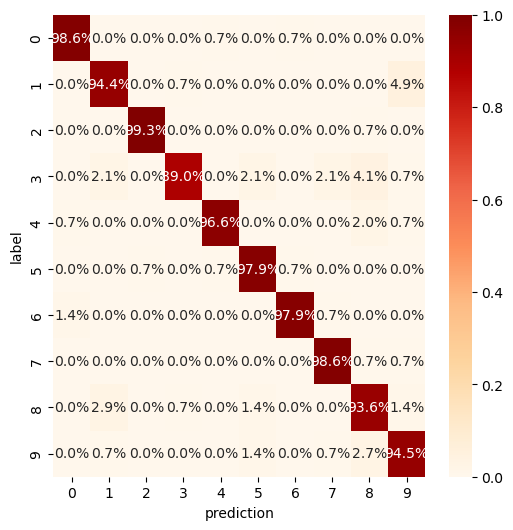

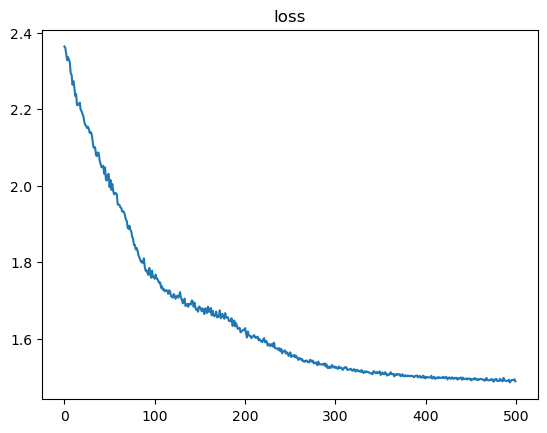

val_loss


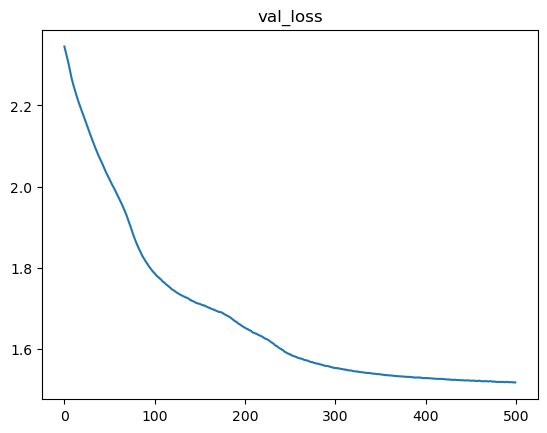

Finished


In [5]:
'''
Main
'''

from sklearn.datasets import load_digits

import torch
torch.cuda.empty_cache()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import json
import os

set_seed_torch(42)

train_logdir = './'

data_split = [0.7, 0.1, 0.2]

class TrainerConfig:
    device = 'cpu' # 'cpu' or 'gpu'
    max_epochs = 500
    batch_size = 1000 #70000 #256
    ini_lr = 5e-4 # initial learning rate
    fin_lr = 1e-6 # final learning rate, if using LinearLR
    gamma = 0.996 # multiplicative factor, if using ExponentialLR
    decayfactor = 0.5 # if using ReduceLROnPlateau
    # patience = 10 # if using ReduceLROnPlateau, not implemented
    betas = (0.9, 0.99)
    eps = 1e-8
    grad_norm_clip = 1.0
    weight_decay = 1e-10
    epoch_save_freq = 0 # set to 0 to only save at the end of the last epoch
    epoch_save_name = train_logdir+'FCNN_'
    num_workers = 0 # for DataLoader, only zero works
    progress_bar = False # whether to show a progress bar
    model_shape = [20]
    dropout = None
    dropout_on_last_layer = False
    

    
# ----------------------------------------------------------------------------

mnist = load_digits()
x = np.array(mnist.data)
y = to_dense(np.array(mnist.target))

assert np.allclose(np.sum(data_split), 1.)
split_idx = np.array(data_split)*len(x)
split_idx = split_idx.astype('int')

# ----------------------------------------------------------------------------

train_set = Dataset(x[:split_idx[0]], y[:split_idx[0]])
val_set = Dataset(x[split_idx[0]:split_idx[-1]], y[split_idx[0]:split_idx[-1]])
test_set = Dataset(x[split_idx[-1]:], y[split_idx[-1]:])

model = FCNN(train_set.x.shape[1], train_set.y.shape[1], TrainerConfig.model_shape 
             )

trainer = Trainer(model, TrainerConfig, train_set, test_set)

log = trainer.train()

test_result = trainer.test()

for key in log.keys():
    plt.figure()
    plt.title(str(key))
    print(key) # in case plt.title does not work
    plt.plot(log[key])
    plt.show()
    
print('Finished')